### Milliken - Replication of Gali 1999

In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import norm
from numpy.linalg import inv, cholesky
from scipy import signal
import statsmodels.api as sm
from random import choices

In [690]:
from svarlr import varlr, irflr, cor, bootstrap, band
#from historical_decomposition import historical_decomposition

In [691]:
def varlrMilliken(series, p):
    
    """
    This is a function I created based on "svarlr.py"
    but adjusted it to account for lags, which the
    origional function fails to do. Origional 
    function is in a seperate python file.
    
    There is no other package to do this is in Python.

    """
    
    (nobs, nvar) = series.shape
    series = np.asarray(series)
    YY = series[p:nobs]
    XX = np.ones([nobs - p, 1 + nvar * p])
    
    for i in range(1, p + 1):
        start_col = 1 + nvar * (i - 1)
        end_col = 1 + nvar * i
        XX[:, start_col:end_col] = series[p - i:nobs - i, :]
    
    # Estimate VAR coefficients
    b = np.linalg.lstsq(XX, YY, rcond=None)[0]
    e = YY - np.dot(XX, b)
    Sig = np.dot(e.conj().transpose(), e) / (nobs - p)
    
    # Extract AR Coefficient Matrices
    AR_matrices = []
    for i in range(p):
        start_idx = 1 + i * nvar
        end_idx = 1 + (i + 1) * nvar
        Ai = b[start_idx:end_idx, :].conj().transpose()
        AR_matrices.append(Ai)
    
    # Sum of AR Coefficients
    A_sum = np.zeros((nvar, nvar))
    for Ai in AR_matrices:
        A_sum += Ai
    
    # Compute Phi1
    Phi1 = np.linalg.inv(np.identity(nvar) - A_sum)
    
    # Compute mu and lvar
    mu = np.dot(Phi1, b[0].conj().transpose())
    lvar = np.dot(Phi1, np.dot(Sig, Phi1.conj().transpose()))
    
    # Long-Run restriction
    theta1 = np.linalg.cholesky(lvar.conj().transpose())
    B = np.dot(np.linalg.inv(Phi1), theta1)
    
    return b, Sig, B, e

In [692]:
## Data from RATS replication file
DATA = pd.read_excel('DATA.xlsx').rename(columns = {'Unnamed: 0' : "Time"})

In [693]:
LAGS=4
NVAR=2
NSTEP= 100
NDRAWS= 500
NSE = 2
IRH = 13
NW = 6

In [694]:
def historical_decomposition(data, B, e, p, detrend, b):
    
    """
    
    Custom historical decomposition based on RATS program.
    There is no function in Python for historical 
    decomposition, so this function is a custom implementation.
    
    """
    
    # data: DataFrame with 'dx' and 'dn'
    # B: Structural impact matrix
    # e: Reduced-form residuals
    # p: Number of lags
    # detrend: 1 if detrended, 0 otherwise
    # b: Coefficient matrix from varlrMilliken
    
    # Compute structural shocks
    eps = np.linalg.solve(B, e.T).T  # Shape: (T, nvar)
    
    T, nvar = e.shape
    
    # Extract VAR coefficient matrices from b
    AR_matrices = []
    for i in range(p):
        start_idx = 1 + i * nvar
        end_idx = 1 + (i + 1) * nvar
        Ai = b[start_idx:end_idx, :].T
        AR_matrices.append(Ai)
    # A_matrices is an array of shape (nvar, nvar, p)
    A_matrices = np.stack(AR_matrices, axis=2)
    
    # Initialize contributions
    contrib_tech = np.zeros((T, nvar))
    contrib_demand = np.zeros((T, nvar))
    
    for shock_idx in range(nvar):
        eps_shock = np.zeros_like(eps)
        eps_shock[:, shock_idx] = eps[:, shock_idx]
    
        contrib = np.zeros((T, nvar))
        for t in range(T):
            if t == 0:
                past_contrib = np.zeros(nvar)
            else:
                past_contrib = np.zeros(nvar)
                for lag in range(1, min(p, t) + 1):
                    A_lag = A_matrices[:, :, lag - 1]
                    past_contrib += A_lag @ contrib[t - lag, :]
    
            # Current structural shock
            eps_t = eps_shock[t, :]
    
            # Contribution from the structural shock
            contrib_shock = B @ eps_t
    
            # Total contribution at time t
            contrib[t, :] = past_contrib + contrib_shock
    
        if shock_idx == 0:
            # Technology shock
            contrib_tech = contrib
        else:
            # Demand shock
            contrib_demand = contrib
    
    # Assign contributions
    dxt = contrib_tech[:, 0]
    dnt = contrib_tech[:, 1]
    dxd = contrib_demand[:, 0]
    dnd = contrib_demand[:, 1]
    dyt = dxt + dnt
    dyd = dxd + dnd
    
    # Adjust for detrending
    if detrend == 1:
        dnt_adj = np.zeros_like(dnt)
        dnd_adj = np.zeros_like(dnd)
        dnt_adj[0] = dnt[0]
        dnd_adj[0] = dnd[0]
        dnt_adj[1:] = dnt[1:] - dnt[:-1]
        dnd_adj[1:] = dnd[1:] - dnd[:-1]
        dnt = dnt_adj
        dnd = dnd_adj
    
    # Compute cumulative sums
    yt = np.cumsum(dyt)
    xt = np.cumsum(dxt)
    nt = np.cumsum(dnt)
    yd = np.cumsum(dyd)
    xd = np.cumsum(dxd)
    nd = np.cumsum(dnd)
    
    if detrend == 1:
        nt = dnt
        nd = dnd
    
    # Compile results
    decomposition = pd.DataFrame({
        'dn' : data.dn,
        'dx' : data.dx,
        'dyt': dyt,
        'dxt': dxt,
        'dnt': dnt,
        'dyd': dyd,
        'dxd': dxd,
        'dnd': dnd,
        'yt': yt,
        'xt': xt,
        'nt': nt,
        'yd': yd,
        'xd': xd,
        'nd': nd
    }, index=data.index[-T:])
    
    return decomposition

In [695]:
def getVars(DATA, gdp, labor, detrend):
    data = DATA.copy()
    yx = data[gdp] ## Aggregate Development Variable
    nx = data[labor] ## Amount of labor
    xx = yx/nx ## productivity 
    xx[0:4] = np.nan

    ## Removing base numbers, and finding first differences
    data['dlabor'] = np.log(data[labor]) - np.log(data[labor].shift(1))
    data['n'] = 100 + np.log(data[labor]/data[labor][4]) * 100
    data['n'][0:4] = np.nan
    data['dn'] = data['n']
    
    ## Detrending Data for Employement
    if detrend == 1:
        #data['n'], n_trend = hpfilter(data.n.dropna(), lamb=1600)
        
        ser = data.n.dropna()
        X = sm.add_constant(np.arange(0,len(ser)))
        model = sm.OLS(np.array(ser), X)
        result = model.fit()

        # Get the linear trend
        trend = result.predict(X)
        detrended_series = ser - trend
        # Detrend the series
        data['dn'] = ([np.nan] * 4 + detrended_series.tolist())
    else:
        data['dn'] = data['dlabor']*100
    data['dn'][0:5] = np.nan

    data['dgdp'] = np.log(data[gdp]) - np.log(data[gdp].shift(1))
    data['y'] = 100 + np.log(data[gdp]/data[gdp][4]) * 100
    data['y'][0:4] = np.nan
    #if detrend == 1:
    #    data['y'], n_trend = hpfilter(data.y.dropna(), lamb=1600)
    data['dy'] = data['dgdp']*100
    data['dy'][0:5] = np.nan

    data['xx'] = data[gdp].div(data[labor])
    data['x'] = 100 + np.log(data['xx']/data['xx'][4]) * 100
    data['x'][0:4] = np.nan
    #if detrend == 1:
    #    data['x'], n_trend = hpfilter(data.x.dropna(), lamb=1600)
    data['dx'] = (np.log(data['xx']) - np.log(data['xx'].shift(1)))*100
    data['dx'][0:5] = np.nan
    
    return data

In [696]:
def plotFig1(data):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))

    # Plot the first scatter plot
    sns.scatterplot(
        data=data[['dn', 'dx']].dropna(), 
        x='dn', 
        y='dx', 
        marker='s',        
        color='black',     
        edgecolor='black',
        ax=axes[0]  # Use the first subplot
    )
    axes[0].set_title('Data', fontsize=16)
    axes[0].set_xlabel('Hours', fontsize=14)
    axes[0].set_ylabel('Productivity', fontsize=14)
    axes[0].axhline(0, color='black', linewidth=1)
    axes[0].axvline(0, color='black', linewidth=1)

    # Plot the second scatter plot
    sns.scatterplot(
        data=data[['dn', 'dxt']].dropna(), 
        x='dn', 
        y='dxt', 
        marker='o',        
        color='gray',     
        edgecolor='black',
        ax=axes[1]  # Use the second subplot
    )
    axes[1].set_title('Technology Component', fontsize=16)
    axes[1].set_xlabel('Hours', fontsize=14)
    axes[1].set_ylabel('Productivity', fontsize=14)
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].axvline(0, color='black', linewidth=1)

    # Plot the third scatter plot
    sns.scatterplot(
        data=data[['dn', 'dxd']].dropna(), 
        x='dn', 
        y='dxd', 
        marker='^',        
        color='darkgray',     
        edgecolor='black',
        ax=axes[2]  # Use the third subplot
    )
    axes[2].set_title('Nontechnology Component', fontsize=16)
    axes[2].set_xlabel('Hours', fontsize=14)
    axes[2].set_ylabel('Productivity', fontsize=14)
    axes[2].axhline(0, color='black', linewidth=1)
    axes[2].axvline(0, color='black', linewidth=1)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


In [697]:
import matplotlib.pyplot as plt

def plotIRF(Cs, Cs_se): 
    # Plot impulse responses to technology shock
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

    # Productivity response to Technology Shock
    axes[0].plot(Cs[0][:IRH], 'k.-', label='Productivity response to Technology Shock')
    axes[0].plot(Cs[0][:IRH] + (Cs_se[0][:IRH]*2), 'k--')
    axes[0].plot(Cs[0][:IRH] - (Cs_se[0][:IRH]*2), 'k--')
    axes[0].set_title('Impulse Response of dx to Technology Shock')
    axes[0].set_xlabel('Periods')
    axes[0].set_ylabel('Response')
    axes[0].legend()
    
    # GDP response to Technology Shock
    axes[1].plot(Cs[2][:IRH], 'k.-', label='GDP response to Technology Shock')
    axes[1].plot(Cs[2][:IRH] + (Cs_se[2][:IRH]*2), 'k--')
    axes[1].plot(Cs[2][:IRH] - (Cs_se[2][:IRH]*2), 'k--')
    axes[1].set_title('Impulse Response of (dx + dnz) to Technology Shock')
    axes[1].set_xlabel('Periods')
    axes[1].set_ylabel('Response')
    axes[1].legend()
    
    # Employment Measure response to Technology Shock
    axes[2].plot(Cs[1][:IRH], 'k.-', label='Employment Measure response to Technology Shock')
    axes[2].plot(Cs[1][:IRH] + (Cs_se[1][:IRH]*2), 'k--')
    axes[2].plot(Cs[1][:IRH] - (Cs_se[1][:IRH]*2), 'k--')
    axes[2].set_title('Impulse Response of dnz to Technology Shock')
    axes[2].set_xlabel('Periods')
    axes[2].set_ylabel('Response')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Plot impulse responses to non-technology shock
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

    # Productivity response to Non-Technology Shock
    axes[0].plot(Cs[3][:IRH], 'k.-', label='Productivity response to Non-Technology Shock')
    axes[0].plot(Cs[3][:IRH] + (Cs_se[3][:IRH]*2), 'k--')
    axes[0].plot(Cs[3][:IRH] - (Cs_se[3][:IRH]*2), 'k--')
    axes[0].set_title('Impulse Response of dx to Non-Technology Shock')
    axes[0].set_xlabel('Periods')
    axes[0].set_ylabel('Response')
    axes[0].legend()
    
    # GDP response to Non-Technology Shock
    axes[1].plot(Cs[5][:IRH], 'k.-', label='GDP response to Non-Technology Shock')
    axes[1].plot(Cs[5][:IRH] + (Cs_se[5][:IRH]*2), 'k--')
    axes[1].plot(Cs[5][:IRH] - (Cs_se[5][:IRH]*2), 'k--')
    axes[1].set_title('Impulse Response of (dx + dnz) to Non-Technology Shock')
    axes[1].set_xlabel('Periods')
    axes[1].set_ylabel('Response')
    axes[1].legend()

    # Employment Measure response to Non-Technology Shock
    axes[2].plot(Cs[4][:IRH], 'k.-', label='Employment Measure response to Non-Technology Shock')
    axes[2].plot(Cs[4][:IRH] + (Cs_se[4][:IRH]*2), 'k--')
    axes[2].plot(Cs[4][:IRH] - (Cs_se[4][:IRH]*2), 'k--')
    axes[2].set_title('Impulse Response of dnz to Non-Technology Shock')
    axes[2].set_xlabel('Periods')
    axes[2].set_ylabel('Response')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [698]:
def getIRF(varD, b, B, IRH, detrend):
    irfs = irflr(b,B,IRH) #Impulse response functions long-run

    C_11 = irfs[0]  # 'dx' response to tech shock
    C_21 = irfs[1]  # 'dn' response to tech shock
    C_12 = irfs[2]  # 'dx' response to non-tech shock
    C_22 = irfs[3]  # 'dn' response to non-tech shock

    C_11s = np.cumsum(C_11)
    C_21s = np.cumsum(C_21)
    C_12s = np.cumsum(C_12)
    C_22s = np.cumsum(C_22)

    if detrend == 1:
        C_21s = C_21
        C_22s = C_22
        
    C_11s_21s = C_11s + C_21s
    C_12s_22s = C_12s + C_22s
        
    var_dx_tech = np.sum(C_11 ** 2)
    var_dnz_tech = np.sum(C_21 ** 2)
    cov_dx_dnz_tech = np.sum(C_11 * C_21)

    # Variance due to non-technology shock
    var_dx_nontech = np.sum(C_12 ** 2)
    var_dnz_nontech = np.sum(C_22 ** 2)
    cov_dx_dnz_nontech = np.sum(C_12 * C_22)

    corr_tech = np.zeros(2)
    corr_nontech = np.zeros(2)
    # Compute conditional correlations

    corr_tech[0] = cov_dx_dnz_tech / np.sqrt(var_dx_tech * var_dnz_tech)## conditional Correlations
    corr_tech[1] = np.sqrt((1 - corr_tech[0]**2) / ((len(varD)/8) - 2))
    
    corr_nontech[0] = cov_dx_dnz_nontech / np.sqrt(var_dx_nontech * var_dnz_nontech) ## conditional Correlations
    corr_nontech[1] = np.sqrt((1 - corr_nontech[0]**2) / ((len(varD)/8) - 2))

    irf_samples = np.zeros((NDRAWS, 4, IRH+1))  

    for i in range(NDRAWS):
        b_bootstrap, Sig_bootstrap, B_bootstrap, e_bootstrap = varlrMilliken(series = varD.sample(n = len(varD), replace=True, ignore_index=True), p=LAGS)
        irf_samples[i] = irflr(b_bootstrap, B_bootstrap, IRH)

    #irf_mean = np.mean(irf_samples, axis=0)


    C_11_boot = irf_samples[:, 0]  # 'dx' response to tech shock
    C_12_boot = irf_samples[:, 2]  # 'dx' response to non-tech shock
    C_21_boot = irf_samples[:, 1]  # 'dn' response to tech shock
    C_22_boot = irf_samples[:, 3]  # 'dn' response to non-tech shock

    C_11s_boot = np.cumsum(C_11_boot, axis = 1)
    C_12s_boot = np.cumsum(C_12_boot, axis = 1)
    C_21s_boot = np.cumsum(C_21_boot, axis = 1)
    C_22s_boot = np.cumsum(C_22_boot, axis = 1)

    if detrend == 1:
        C_21s_boot = C_21_boot
        C_22s_boot = C_22_boot
        
    C_11s_21s_boot = C_11s_boot + C_21s_boot
    C_12s_22s_boot = C_12s_boot+ C_22s_boot
    
    ## Standard Errors of Impulse Response Functions
    C_11s_se = np.std(C_11s_boot, axis=0)
    C_21s_se = np.std(C_21s_boot, axis=0)
    C_12s_se = np.std(C_12s_boot, axis=0)
    C_22s_se = np.std(C_22s_boot, axis=0)
    C_11s_21s_se = np.std(C_11s_21s_boot, axis=0)
    C_12s_22s_se = np.std(C_12s_22s_boot, axis=0)
    
    Cs = [C_11s, C_21s, C_11s_21s, C_12s, C_22s, C_12s_22s]
    Cs_se = [C_11s_se, C_21s_se, C_11s_21s_se, C_12s_se, C_22s_se, C_12s_22s_se]
    
    return corr_tech, corr_nontech, Cs, Cs_se

In [704]:
def repGali(DATA):
    gdp = 'GDPQ'
    for labor in ['LPMHU', 'LHEM']: ##Choose Hours or Number Employed
        print(labor)
        for detrend in range(2): #Binary to decide.
            print(detrend)
            data = getVars(DATA, gdp, labor, detrend) # get dy, dn, dx
            
            corr_uncon = np.zeros(2)
            corr_uncon[0] = np.corrcoef(data.dx.dropna(),data.dn.dropna())[0,1] ## Unconditional Correlations
            corr_uncon[1] = np.sqrt((1 - corr_uncon[0]**2) / (len(data.dx.dropna()) - 2))
            
            varD = data[['dx', 'dn']].dropna()
            b, Sig, B, e = varlrMilliken(series = varD, p=LAGS)
            
            corr_tech, corr_nontech, Cs, Cs_se = getIRF(varD, b, B, IRH, detrend) ## Gets conditional correlations and the IRF and standard errors
            
            decomposition = historical_decomposition(varD, B, e, LAGS, detrend, b) ## Gets decomposed dy, y, dn, n, dx, x
            

            coefficients = [corr_uncon[0], corr_tech[0], corr_nontech[0]]
            standard_errors = [corr_uncon[1], corr_tech[1], corr_nontech[1]]
            Table1 = pd.DataFrame(
                [coefficients, standard_errors],
                index=['Correlation Coefficient', 'Standard Error'],
                columns= ['Unconditional', 'Technology', 'Non-Technology']
            )
            print(Table1)
            plt.plot(decomposition["yt"])
            #plotFig1(decomposition)
            #plotIRF(Cs, Cs_se)
            
    return decomposition#(corr_uncon, corr_tech, corr_nontech) #decomposition# Cs_se #sam #decomposition#(corr_uncon, corr_tech, corr_nontech)

LPMHU
0


C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\L

                         Unconditional  Technology  Non-Technology
Correlation Coefficient      -0.257657   -0.823320        0.263596
Standard Error                0.071039    0.122764        0.208646
1


C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\L

                         Unconditional  Technology  Non-Technology
Correlation Coefficient      -0.284951   -0.494174       -0.210165
Standard Error                0.070473    0.188039        0.211464
LHEM
0


C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\L

                         Unconditional  Technology  Non-Technology
Correlation Coefficient      -0.015301   -0.841964        0.643124
Standard Error                0.073513    0.116698        0.165631
1


C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_29208\3278803900.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\L

                         Unconditional  Technology  Non-Technology
Correlation Coefficient      -0.070675   -0.103393       -0.418192
Standard Error                0.073338    0.215136        0.196474


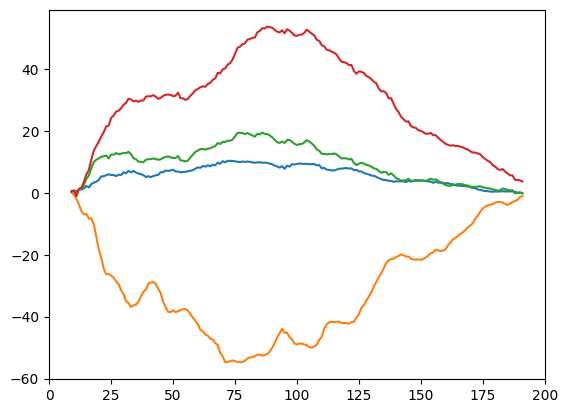

In [706]:
doop = repGali(DATA)